# Expected information density (EID), and active sampling simulation

This colab was inspired by the "[Ergodic_Information_Harvesting_Tutorial.ipynb](https://github.com/elifesciences-publications/Ergodic-Information-Harvesting/blob/master/Tutorial/Ergodic_Information_Harvesting_Tutorial.ipynb)" by Chen Chen & Malcolm MacIver & Todd Murphey, August 2019.

More information can be found in the references
*   Varella et al., (2023) Active Sampling in Primate Vocal Interactions.
*   Chen et al., (2020) Tuning movement for sensing in an uncertain world. *eLife* 9:e52371.


In [3]:
#@title Imports and pre-defined functions

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, entropy
from tqdm import tqdm

Here, we have an agent (a marmoset) that is emitting vocalizations and receiving (or not) a response. Let's say that we can project the space of vocalizations into a single parameter $\theta$ that goes from -5 to 5 (by changing that scale, this parameter could represent, for example, the duration of the vocalization, the frequency of the vocalization, etc, or the principal component of many different acoustic parameters).

We are assuming here that different vocalizations have different likelihoods of getting a response. The computational agent simulating a marmoset will choose vocalizations and read the probability of receiving a response, and it wants to learn what the best vocalization is (i.e. the vocalization that maximizes the probability of response).

As part of the nature of the problem, we have an observation model $\Upsilon(\theta,x)$ that returns the probability of receiving a response giving that the optimal vocalization is $\theta$ and the agent sampled a vocalization $x$. Let's assume that the observation model is a Gaussian with deviation $\sigma_1$:
$$
\Upsilon(\theta, x) = \exp{\left[-\left(\frac{x-\theta}{2\sigma_1}\right)^2 \right]}
$$

Notice that this function ranges from $0$ to $1$, and the maximum is reached when $x = \theta$. The parameter $\sigma_1$ here is how broad that function is, still peaked at $1$, which means that a big $\sigma_1$ makes it easy for $x$ to achieve a high response rate. We can use an extra parameter max_rate to multiply the exponential so that the maximum probability is not 1 anymore, but max_rate. Let's call V the variable that represents the response rate, so ideally, $V = \Upsilon(\theta, x)$.

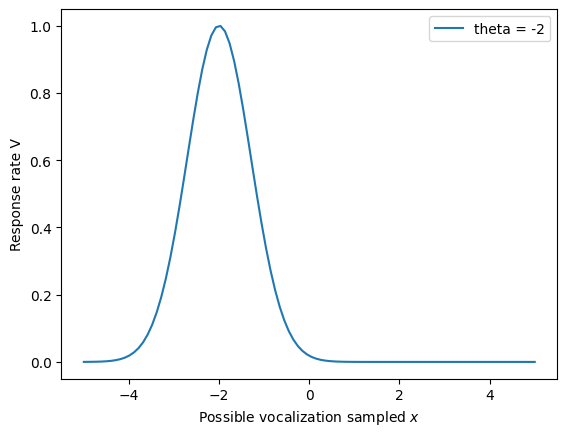

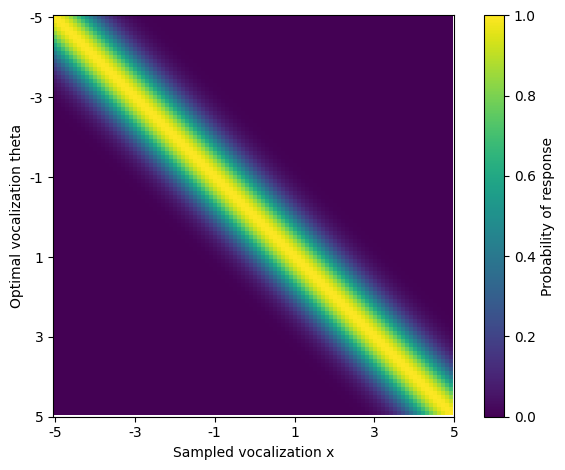

In [5]:
# @title Figure 1: Observation model example for theta = -2 (unknown x) and plot for Upsilon

def ObservationModel(theta=-2, x=0, sigma = 0.5):
    return np.exp((x-theta)*(theta-x)/(4*sigma*sigma))

VocalizationSpaceSize = 100
VocalizationSpace = np.linspace(-5, 5, VocalizationSpaceSize)

upsilon = ObservationModel(-2,VocalizationSpace)
plt.plot(VocalizationSpace,upsilon)
plt.xlabel(r'Possible vocalization sampled $x$')
plt.ylabel('Response rate V')
plt.legend(['theta = -2'])
plt.show()

Obsv = np.zeros([VocalizationSpaceSize,VocalizationSpaceSize])
for ix in range(len(VocalizationSpace)):
    for itheta in range(len(VocalizationSpace)):
        Obsv[itheta,ix]=ObservationModel(VocalizationSpace[itheta],VocalizationSpace[ix],0.5)

plt.imshow(Obsv)
plt.xticks([0,20,40,60,80,100],[-5,-3,-1,1,3,5])
plt.yticks([0,20,40,60,80,100],[-5,-3,-1,1,3,5])
plt.xlabel('Sampled vocalization x')
plt.ylabel('Optimal vocalization theta')
plt.colorbar().set_label('Probability of response')
plt.tight_layout()
plt.show()

The assumption in this simulation is that the agent chooses a vocalization $x$ and receives a response that can be used to encode the measurement $V$ via $V = \Upsilon(\theta,x) + \epsilon$, where $\epsilon$ is the measurement error. Notice that the response probability is a continuous variable $V$ from 0 to 1, and in my actual simulations I adapted the problem so that the measurement of the agent is actually a discrete variable $r$ that is equal to either 0 or 1, which represents whether there was a response or not.

Let's initialize the belief of the agent as a uniform probability distribution for $\theta$ that goes from -5 to 5.

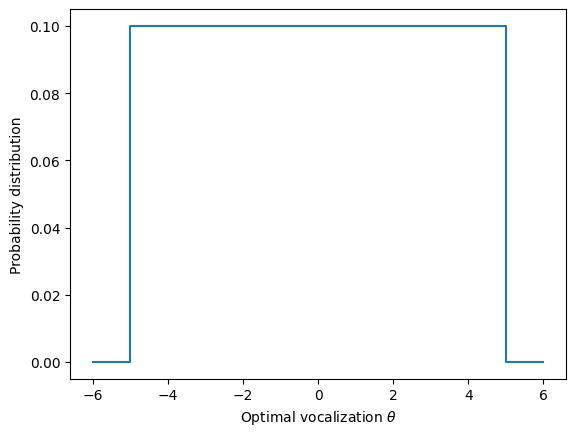

In [6]:
# @title Figure 2: Initial belief for optimal vocalization $\theta$

plt.plot([-6,-5,-5,5,5,6],[0,0,0.1,0.1,0,0])
plt.ylabel('Probability distribution')
plt.xlabel(r'Optimal vocalization $\theta$')
plt.show()

So how does the agent update the new belief $p(\theta|V,x)$ given the current sampled vocalization $x$ and the measured response rate $V$? Using the following Bayesian filter:

$$
p(\theta~\rvert~V, x) = \dfrac{p(V~\rvert~\theta, x)~p(\theta)}{p(V~\rvert~x)} = \eta~p(V~\rvert~\theta, x)~p(\theta)
$$

So we need to calculate the likelihood $p(V|\theta,x)$. This is the same thing as how likely the measurement $V$ is given the $\theta$. Since $V = \Upsilon(\theta,x) + \epsilon$, we can say that the likelihood is a Gaussian function in which the maximum likelihood is when $V = \Upsilon(\theta,x)$, i.e.,:

$$
p(V~\rvert~\theta, x) = \eta \,\exp{\left[-\frac{(V-\Upsilon(\theta,x))^2}{2\sigma_2^2}\right]}
$$

where $\eta$ is just a normalizing factor and $\sigma_2$ is the standard deviation associated with the measurement error $\epsilon$.

Let's calculate an example of the likelihood, and then use it to update the initial belief. Let's say that the agent chose x = 2, and see what happens with the likelihood if the measurement was either 0, 0.5, or 1.


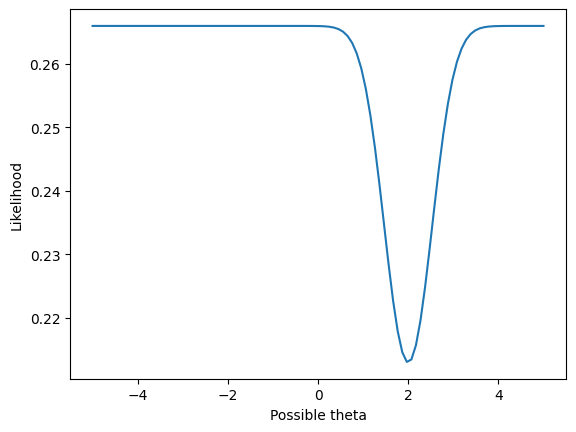

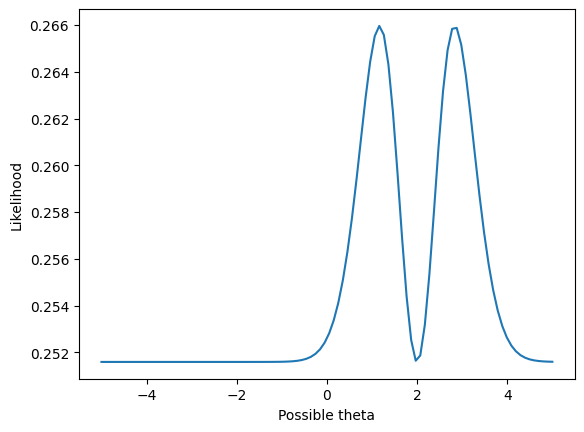

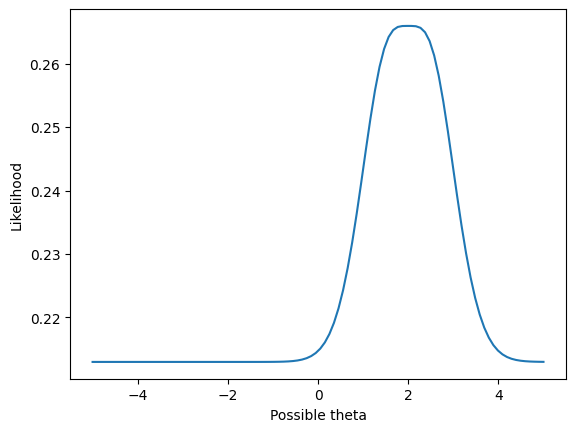

In [7]:
# @title Figure 3: Gaussian likelihood example for x = 2 and V = (0,0.5,1).

def GaussianLikelihood(V, theta, x, sigma2=1.5):
    pV = norm.pdf(V,ObservationModel(theta,x), sigma2)
    return pV

for v in [0,0.5,1]:
    likelihood = GaussianLikelihood(v,VocalizationSpace,2)
    plt.plot(VocalizationSpace,likelihood)
    plt.xlabel('Possible theta')
    plt.ylabel('Likelihood')
    plt.show()

Notice that there is a valley when V = 0. If the agent chose x = 2 and it measure V = 0, it measured the chance of response to be 0 when the vocalization was equal to 2. That means that it is extremely unlikely that the optimal vocalization θ is also equal to 2, because if x=θ=2, V should be high instead of 0.

Notice that there are two peaks when V = 0.5. The valley at θ=2 happens for a similar reason as in V = 0, but θ should be not too far from 2 since the chance of response was 0.5, instead of 0, so it is either a little lower than 2, or a little higher than 2. That creates the two peaks, one for the lower value, and one for the higher value.

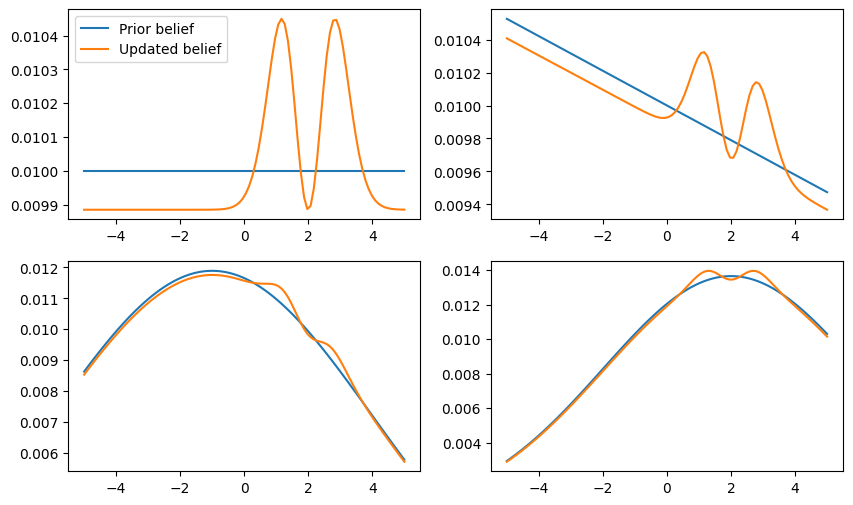

In [8]:
# @title Figure 4: Examples of updating belief $p(\theta)$ if $V = 0.5$

def UpdateBelief(pTheta, likelihood):
    updatedP = pTheta * likelihood
    updatedP /= updatedP.sum()
    return updatedP

V = 0.5

likelihood = GaussianLikelihood(V,VocalizationSpace,2)

pTheta = np.ones(len(VocalizationSpace))*0.1
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

fig, axs = plt.subplots(2, 2, figsize=(10,6))
axs[0, 0].plot(VocalizationSpace,pTheta,label='Prior belief')
axs[0, 0].plot(VocalizationSpace,updatedP,label='Updated belief')
axs[0, 0].legend()

pTheta = np.linspace(1,0.9,VocalizationSpaceSize)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[0, 1].plot(VocalizationSpace,pTheta,label='Prior belief')
axs[0, 1].plot(VocalizationSpace,updatedP,label='Updated belief')

pTheta = norm.pdf(VocalizationSpace,-1,5)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[1, 0].plot(VocalizationSpace,pTheta,label='Prior belief')
axs[1, 0].plot(VocalizationSpace,updatedP,label='Updated belief')

pTheta = norm.pdf(VocalizationSpace,2,4)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[1, 1].plot(VocalizationSpace,pTheta,label='Prior belief')
axs[1, 1].plot(VocalizationSpace,updatedP,label='Updated belief')

plt.show()



Now, given a sampled vocalization $x$, we know how to update the belief $p(\theta)$. But how to choose the best vocalization to update the belief? We will use the expected information density EID(x).

#### Expected information density EID(x)

Each belief has a Shannon entropy associated, which is calculated via $S[p(\theta)] = - \sum_{\theta} p(\theta) \log p(\theta)$. The lower the entropy is, the more certainty we have in the belief. Therefore, the best vocalization to sample, is the one that lowers the most the belief after updating, i.e., the one with the lowest $\Delta S = S[p(\theta)] - S[p(\theta|V,x)]$. For example, for each of the previous 4 examples,

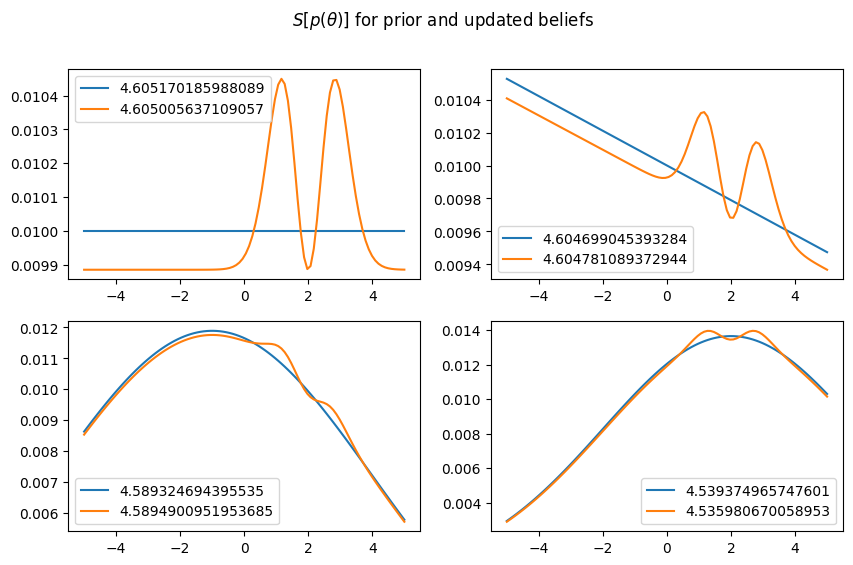

In [ ]:
# @title Figure 5: Examples of information change $\Delta S$

def Entropy(pTheta, likelihood):
    updatedP = pTheta * likelihood
    updatedP /= updatedP.sum()
    return updatedP

pTheta = np.ones(len(VocalizationSpace))*0.1
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

fig, axs = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle(r'$S[p(\theta)]$ for prior and updated beliefs')
axs[0, 0].plot(VocalizationSpace,pTheta,label=entropy(pTheta))
axs[0, 0].plot(VocalizationSpace,updatedP,label=entropy(updatedP))
axs[0, 0].legend()

pTheta = np.linspace(1,0.9,VocalizationSpaceSize)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[0, 1].plot(VocalizationSpace,pTheta,label=entropy(pTheta))
axs[0, 1].plot(VocalizationSpace,updatedP,label=entropy(updatedP))
axs[0, 1].legend()

pTheta = norm.pdf(VocalizationSpace,-1,5)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[1, 0].plot(VocalizationSpace,pTheta,label=entropy(pTheta))
axs[1, 0].plot(VocalizationSpace,updatedP,label=entropy(updatedP))
axs[1, 0].legend()

pTheta = norm.pdf(VocalizationSpace,2,4)
pTheta /= pTheta.sum()

updatedP = UpdateBelief(pTheta, likelihood)

axs[1, 1].plot(VocalizationSpace,pTheta,label=entropy(pTheta))
axs[1, 1].plot(VocalizationSpace,updatedP,label=entropy(updatedP))
axs[1, 1].legend()

plt.show()

Given a prior distribution, the model will simulate what would happen when sampling each value in the whole vocalization space (it will go loop through all values of $\theta$), and for each value of $x$, it will be estimate what the updated belief would be for for each value of $V$ (another loop through $V$).

For each $V$, we calculate the entropy reduction $\Delta S$ for each potential vocalization $x$, which gives a $\Delta S(V,x)$, in function of $x$. Then, we calculate the measurement probability $p(V|x) = \int_{\theta} p(\theta)p(V~\rvert~\theta, x) d\theta$, which we use as the weight of $\Delta S(V,x)$. Finally, we integrate over all possible values of $V$, so that
	$$
	\text{EID}(x) = \text{E} \left[ \Delta S \right] = \int_V p(V~\rvert~x)~\Delta S(V, x) dV
	$$

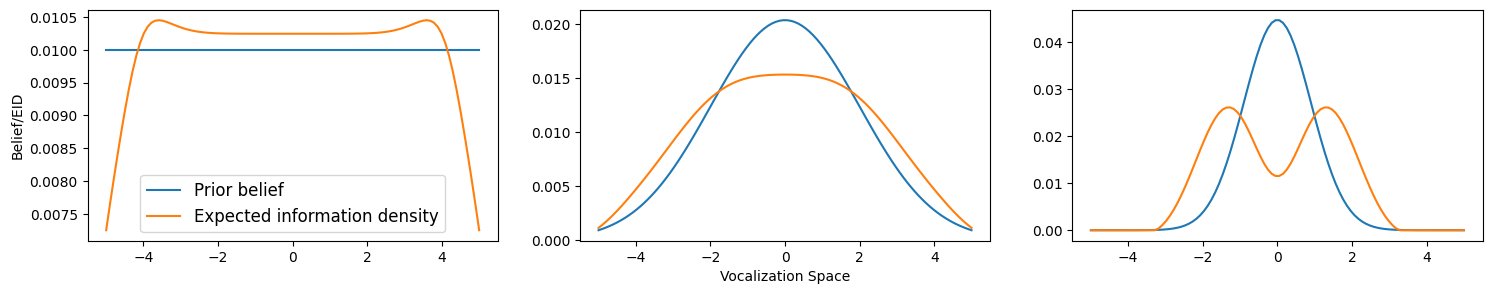

In [ ]:
# @title Figure 6: Examples of Expected Information Density

def ObservationModel(theta=2, x=2, sigma = 1):
    upsilon = norm.pdf(theta,x,sigma)
    upsilon /= max(upsilon)
    return upsilon

def EntropyReduction(priorP,updatedP):
    return entropy(priorP) - entropy(updatedP)

def UpdateBelief(pTheta, likelihood):
    updatedP = pTheta * likelihood
    updatedP /= updatedP.sum()
    return updatedP

def GaussianLikelihood(V, theta, x, sigma2,sigma1):
    pV = norm.pdf(V,ObservationModel(theta,x,sigma1),sigma2)
    return pV

def CalculateEID(MeasurementSpace, VocalizationSpace, belief,sigma2=0.3,sigma1=1):
    pVx = []
    SxV = []

    for V in MeasurementSpace:

        Sxv_spec = []
        likelihoods = []
        for x_idx in range(len(VocalizationSpace)):
            x = VocalizationSpace[x_idx] # Try one location
            likelihood = GaussianLikelihood(V, VocalizationSpace, x, sigma2,sigma1) # Likelihood for that location
            potential_belief = UpdateBelief(belief, likelihood) # New belief for that location and measurement
            Sxv_spec.append(EntropyReduction(belief,potential_belief)) # Reduction in entropy for that location and measurement
            likelihoods.append(likelihood) # All likelihoods

        SxV.append(Sxv_spec)
        pVx.append(likelihoods @ belief)

    SxV = np.array(SxV)
    pVx = np.array(pVx)

    EID = SxV*pVx
    EID = EID.sum(axis=0)
    EID[EID < 0] = 0
    EID /= EID.sum()

    return EID

MeasurementSpace = np.linspace(0,1,10)

belief = np.ones(len(VocalizationSpace))
belief /= belief.sum()
belief1 = belief
EID1 = CalculateEID(MeasurementSpace,VocalizationSpace,belief1)

belief = norm.pdf(VocalizationSpace,0,2)
belief /= belief.sum()
belief2 = belief
EID2 = CalculateEID(MeasurementSpace,VocalizationSpace,belief2)

belief = norm.pdf(VocalizationSpace,0,0.9)
belief /= belief.sum()
belief3 = belief
EID3 = CalculateEID(MeasurementSpace,VocalizationSpace,belief3)

fig, axs = plt.subplots(1, 3, figsize=(18,3))
axs[0].plot(VocalizationSpace,belief1,label='Prior belief')
axs[0].plot(VocalizationSpace,EID1,label='Expected information density')
axs[0].legend(fontsize=12)
axs[0].set_ylabel('Belief/EID')
axs[1].plot(VocalizationSpace,belief2)
axs[1].plot(VocalizationSpace,EID2)
axs[1].set_xlabel('Vocalization Space')
axs[2].plot(VocalizationSpace,belief3)
axs[2].plot(VocalizationSpace,EID3)
plt.show()

In the example above, the agent has access to the actual value of V after each vocalization, but in our simulations, the agent only had access to a discrete to whether it got a response or not (a discrete variable that is either 1 or 0). Let's say that $r \in \{0,1\}$ is the variable that represents the response, $r = 1$ if there is a response. To updated the belief given the response,

$$
p(\theta~\rvert~r,x) = \dfrac{p(r~\rvert~\theta,x)~p(\theta)}{p(r~\rvert~x)} = \eta~p(r~\rvert~\theta)~p(\theta)
$$

Notice however that $p(r~\rvert~\theta,x)$, i.e., the chance of receiving a response given $\theta$ and x, is the observational model $\Upsilon(\theta,x)$, so

$$
p(\theta~\rvert~r=1,x) = \eta~\Upsilon(\theta,x)~p(\theta)
$$

Likewise,

$$
p(\theta~\rvert~r=0,x) = \eta~\left(1-\Upsilon(\theta,x)\right)~p(\theta)
$$

For the active sampling model, the agent should pick the vocalization that it expects to yield the maximal learning, i.e., the one that optimizes the expected information density. This can be done using np.random.choice, and setting the parameter p to be the EID distribution.

Using the functions we implemented here, we can implement a simulation of the agent updating the belief about the best vocalization. Basically, each agent should iteratively establish what is the current belief, calculate the EID given the current belief, sample a new vocalization $x$ given the EID, get a response $r$ from the vocalization $x$, and use that response $r$ to update the belief.

In [ ]:
# Pseudocode

# Some implementation tips:
# - Define some variables before everything, e.g.
# --- a range for possible vocalizations, and a range for possible measurements V
# --- theta
# --- number of iterations
# --- initial uniform belief
# --- sigma1, sigma2
# - For each iteration:
# --- calculate the EID from the belief
# --- sample a vocalization from the EID
# --- calculate the measurement


In [1]:
def ObservationModel(theta, x, sigma, MaxRate):
    # Make sure either theta is an array, otherwise it always returns 1
    return np.exp((x-theta)*(theta-x)/(4*sigma*sigma))*MaxRate

def EntropyReduction(priorP,updatedP):
    return entropy(priorP) - entropy(updatedP)

def UpdateBelief(belief1,ResponseFlag,x,VocalizationSpace, sigma1, MaxRate):
    if ResponseFlag:
        belief = belief1*ObservationModel(VocalizationSpace,x,sigma1,MaxRate)
        belief = belief/belief.sum() #normalizar belief
    else:
        belief = belief1*(1-ObservationModel(VocalizationSpace,x,sigma1,MaxRate))
        belief = belief/belief.sum() #normalizar belief
    return belief

def GaussianLikelihood(V, theta, x, sigma2,sigma1,MaxRate):
    pV = norm.pdf(V,ObservationModel(theta,x,sigma1,MaxRate),sigma2)
    return pV

def CalculateEID(MeasurementSpace,VocalizationSpace,belief,sigma1,sigma2):
    pVx = []
    SxV = []

    for V in MeasurementSpace:

        Sxv_spec = []
        likelihoods = []
        for x_idx in range(len(VocalizationSpace)):
            x = VocalizationSpace[x_idx] # Try one location in the vocalization space
            likelihood = GaussianLikelihood(V, VocalizationSpace, x, sigma1,sigma2,MaxRate) # Likelihood for that location
            potential_belief = UpdateBeliefWithV(belief, likelihood) # New belief for that location and measurement
            Sxv_spec.append(EntropyReduction(belief,potential_belief)) # Reduction in entropy for that location and measurement
            likelihoods.append(likelihood) # All likelihoods

        SxV.append(Sxv_spec)
        pVx.append(likelihoods @ belief)

    SxV = np.array(SxV)
    pVx = np.array(pVx)

    EID = SxV*pVx
    EID = EID.sum(axis=0)
    EID[EID < 0] = 0
    EID /= EID.sum()

    return EID

def UpdateBeliefWithV(pTheta, likelihood):
    updatedP = pTheta * likelihood
    updatedP /= updatedP.sum()
    return updatedP

def CheckIfResponded(theta,x,sigma1,sigma2,MaxRate):
    #V = norm.pdf(theta,x,sigma1)
    V = ObservationModel(theta, x, sigma1,MaxRate)
    #V = np.clip(ObservationModel(theta, x, sigma1) + np.random.normal(0,5),0,1)
    return np.random.binomial(1,V)

In [4]:
# @title Dyadic simulations

# Number of bins in the vocalization space
VocalizationSpaceSize = 100
# Vocalization space from -5 to 5
VocalizationSpace = np.linspace(-5, 5, VocalizationSpaceSize)

# Parameters
sigma1 = 0.9 # sigma_1
sigma2 = 0.3 # sigma_2
MaxRate = 0.5 # maximum likelihood of response, parameter that multiply the
# observation model so that the maximum probability of response is not
# necessarily 100%
spontaneous_rate = 0.8 # chance of vocalizazing in the absence of a previous
#                        response
N_iterations = 100//2 # number of iterations in the simulation. Divided by two
# becase in each repetition of the for-loop, the variable "iteration" is
# increase twice: once per agent. In the paper, we used 300//2.
n_boot = 3 # number of times the simulation should be repeated. In the paper,
#            we repeated 100 times.
theta = -2 # optimal vocalization (the one that maximizes response likelihood)

# Space of possible values of V, used for the calculation of the EID only.
MeasurementSpace = np.linspace(0,MaxRate,int(MaxRate*10))

# Variables to store relevant data and metadata of the simulations
vocs_pac_boot = np.zeros([n_boot, 2*N_iterations])
ID_boot = np.zeros([n_boot, 2*N_iterations])
response_boot = np.zeros([n_boot, 2*N_iterations])
session_boot = np.zeros([n_boot, 2*N_iterations])

#for bootstrap_iter in range(n_boot):
for bootstrap_iter in tqdm(range(n_boot)):

    belief1 = np.ones(len(VocalizationSpace))
    belief1 /= belief1.sum()

    belief2 = np.ones(len(VocalizationSpace))
    belief2 /= belief2.sum()

    ResponseFlag = 0
    V1to2 = 0
    V2to1 = 0

    # Initial vocalizations
    iteration = 0

#    for i in tqdm(range(N_iterations)):
    for i in range(N_iterations):

        # Agent 1
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            # Calculate the EID
            EID = CalculateEID(MeasurementSpace,VocalizationSpace,belief1,sigma2,sigma1)
            # Use the EID to choose a vocalization
            x = np.random.choice(VocalizationSpace,1,p=EID)
            # Store the data
            vocs_pac_boot[bootstrap_iter,iteration] = x
            ID_boot[bootstrap_iter,iteration] = 1
            response_boot[bootstrap_iter,iteration] = ResponseFlag
            session_boot[bootstrap_iter,iteration] = bootstrap_iter
            # Check if there will be a response
            ResponseFlag = CheckIfResponded(theta,x,sigma1,sigma2,MaxRate)
            belief1 = UpdateBelief(belief1, ResponseFlag, x, VocalizationSpace, sigma1,MaxRate)
            belief1 /= belief1.sum()
        else:
            ResponseFlag = False # If there was no vocalization, there was no response

        iteration += 1

        # Agent 2
        if np.random.binomial(1,spontaneous_rate) or ResponseFlag:
            EID = CalculateEID(MeasurementSpace,VocalizationSpace,belief2,sigma2,sigma1)
            x = np.random.choice(VocalizationSpace,1,p=EID)
            vocs_pac_boot[bootstrap_iter,iteration] = x
            ID_boot[bootstrap_iter,iteration] = 2
            response_boot[bootstrap_iter,iteration] = ResponseFlag
            session_boot[bootstrap_iter,iteration] = bootstrap_iter
            ResponseFlag = CheckIfResponded(theta,x,sigma1,sigma2,MaxRate)
            belief2 = UpdateBelief(belief2, ResponseFlag, x, VocalizationSpace, sigma1,MaxRate)
            belief2 /= belief2.sum()
        else:
            ResponseFlag = False

        iteration += 1


100%|██████████| 3/3 [00:44<00:00, 14.81s/it]


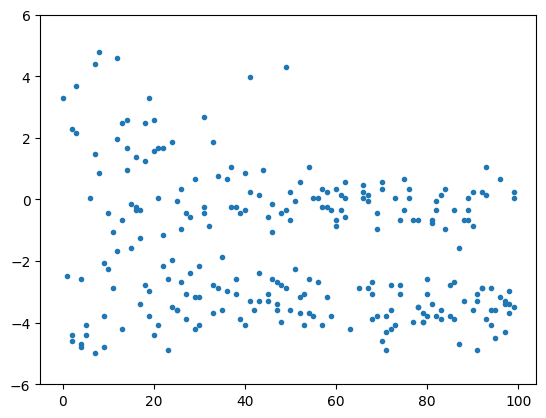

In [5]:
vocs = []
times = []
for i in range(vocs_pac_boot.size):
    pac = vocs_pac_boot[i//vocs_pac_boot.shape[1],i%vocs_pac_boot.shape[1]]
    if pac != 0:
        vocs.append(pac)
        times.append(i%vocs_pac_boot.shape[1])
vocs = np.array(vocs)
times = np.array(times)

plt.plot(times,vocs,'.')
plt.ylim([-6,6])
plt.show()